#### Relationship Method of Admission with Student Success or Dropout Risks 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spQ3.csv')
df.head()

,Application mode,Application order,Course,Previous qualification,Previous qualification (grade),Admission grade,Target_status
0,17,5,171,1,122.0,127.3,1
1,15,1,9254,1,160.0,142.5,2
2,1,5,9070,1,122.0,124.8,1
3,17,2,9773,1,122.0,119.6,2
4,39,1,8014,1,100.0,141.5,2


In [3]:
df.shape

(4424, 7)

In [4]:
# Set labels 1 = Dropout, 2 = Enrolled, 3 = Graduate
target_map = {1:"Dropout", 2:"Enrolled", 3:"Graduate"}
df["Status"] = df["Target_status"].map(target_map)

sns.set(style="whitegrid")


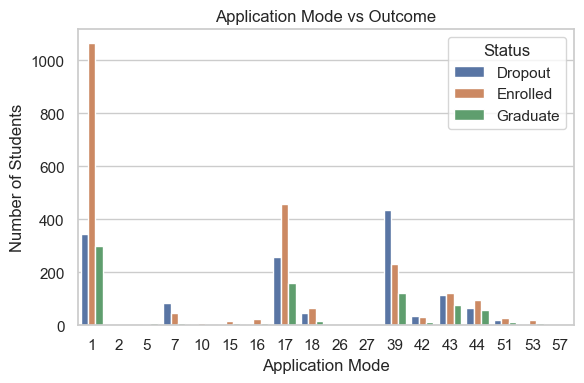

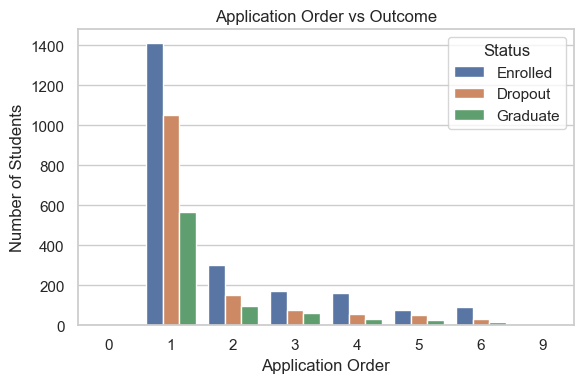

C:\Users\shafi\AppData\Local\Temp\ipykernel_2540\3177407694.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set1")


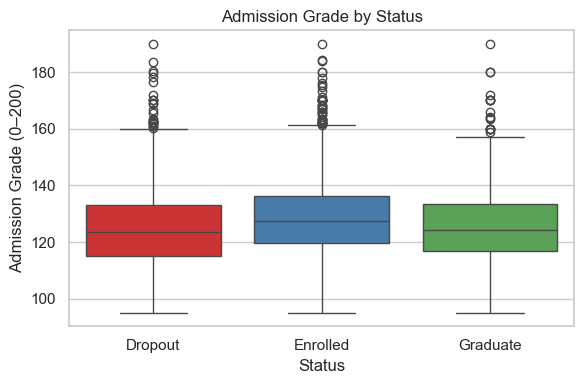

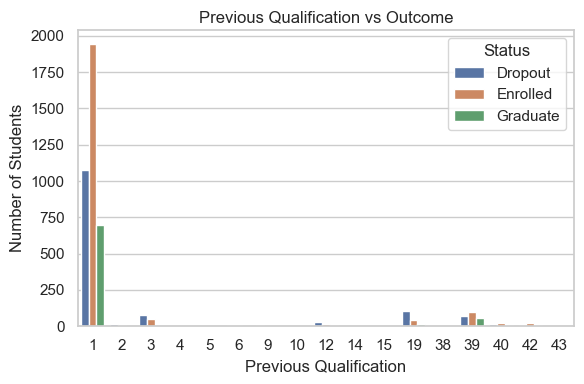

In [16]:
# Figure 3.1 – Application Mode vs Outcome

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application mode", hue="Status")
plt.title("Application Mode vs Outcome")
plt.xlabel("Application Mode")
plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

# Figure 3.2 – Application Order vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application order", hue="Status")
plt.title("Application Order vs Outcome")
plt.xlabel("Application Order")
plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

# Figure 3.3 – Admission Grade by Status
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set1")
plt.title("Admission Grade by Status")
plt.xlabel("Status")
plt.ylabel("Admission Grade (0–200)")
plt.tight_layout()
plt.show()

# Figure 3.4 – Previous Qualification vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Previous qualification", hue="Status")
plt.title("Previous Qualification vs Outcome")
plt.xlabel("Previous Qualification")
plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout()
plt.show()



c:\Users\shafi\Documents\GitHub\DataScienceProject\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Results:
              precision    recall  f1-score   support

           1      0.527     0.514     0.520       284
           2      0.686     0.627     0.655       442
           3      0.319     0.409     0.358       159

    accuracy                          0.551       885
   macro avg      0.510     0.517     0.511       885
weighted avg      0.569     0.551     0.558       885


Random Forest Results:
              precision    recall  f1-score   support

           1      0.463     0.458     0.460       284
           2      0.614     0.695     0.652       442
           3      0.308     0.201     0.243       159

    accuracy                          0.530       885
   macro avg      0.461     0.451     0.452       885
weighted avg      0.510     0.530     0.517       885



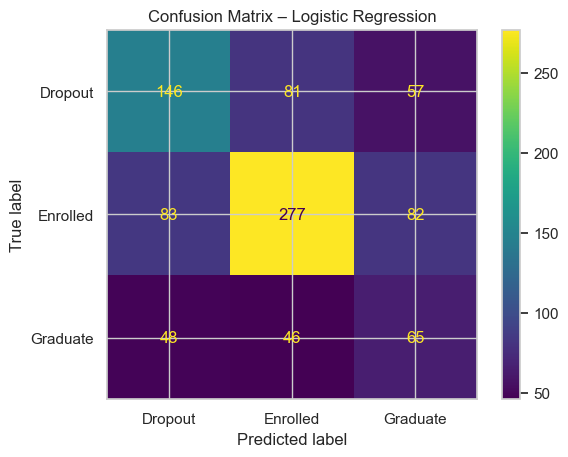

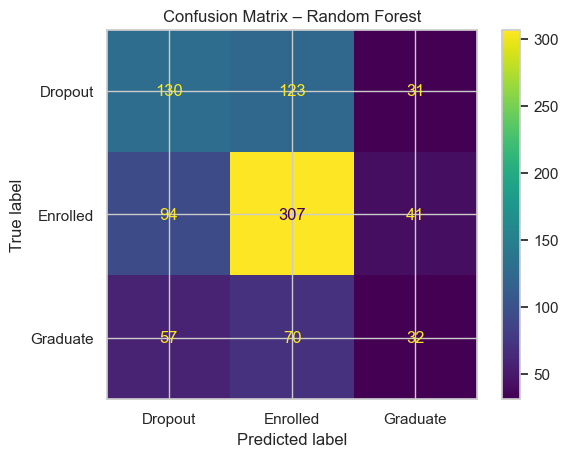

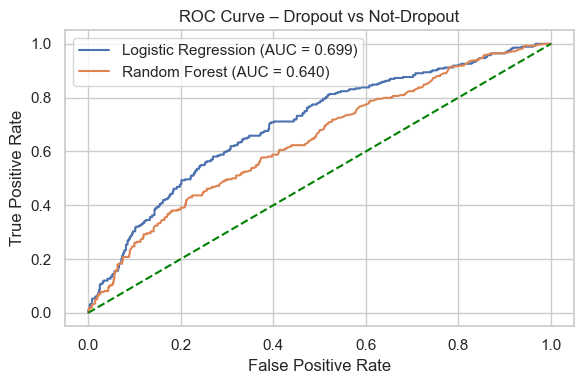


Top Admission Predictors (Random Forest):
Admission grade                   0.360839
Previous qualification (grade)    0.255725
Application order                 0.068604


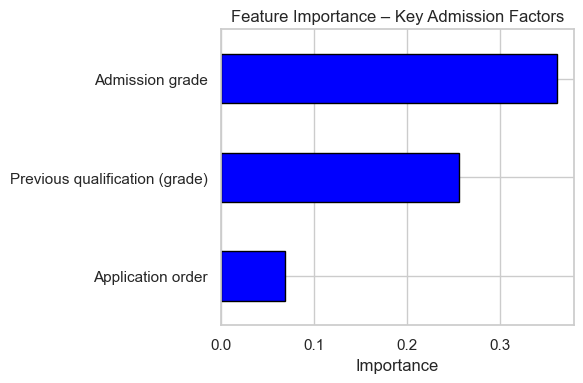

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Features (admission related)
features_q3 = [
    "Application mode", "Application order", "Course",
    "Previous qualification", "Previous qualification (grade)",
    "Admission grade"
]

X = df[features_q3].copy()
y = df["Target_status"].astype(int)   # 1=Dropout, 2=Enrolled, 3=Graduate

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Separate numeric & categorical
num_cols = ["Application order", "Previous qualification (grade)", "Admission grade"]
cat_cols = [c for c in features_q3 if c not in num_cols]

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    sparse_threshold=0
)

# Models
log_clf = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1500, class_weight="balanced", multi_class="ovr"))
])

rf_clf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1
    ))
])

# Train models
log_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Evaluate - classification report
print("Logistic Regression Results:")
y_pred_log = log_clf.predict(X_test)
print(classification_report(y_test, y_pred_log, digits=3))

print("\nRandom Forest Results:")
y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=3))

# Confusion Matrix 
ConfusionMatrixDisplay.from_estimator(log_clf, X_test, y_test, display_labels=["Dropout","Enrolled","Graduate"])
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=["Dropout","Enrolled","Graduate"])
plt.title("Confusion Matrix – Random Forest")
plt.show()

# ROC Curve - Logistic Regression vs Random Forest

y_bin = (y_test == 1).astype(int)  # Dropout=1, Enrolled/Graduate=0

log_pos_idx = np.where(log_clf.named_steps["clf"].classes_ == 1)[0][0]
rf_pos_idx  = np.where(rf_clf.named_steps["clf"].classes_  == 1)[0][0]

# Proabability
proba_log = log_clf.predict_proba(X_test)[:, log_pos_idx]
proba_rf  = rf_clf.predict_proba(X_test)[:, rf_pos_idx]

fpr_log, tpr_log, _ = roc_curve(y_bin, proba_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_bin, proba_rf)

auc_log = roc_auc_score(y_bin, proba_log)
auc_rf  = roc_auc_score(y_bin, proba_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1], [0,1], "--", color="green")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Dropout vs Not-Dropout")
plt.legend()
plt.tight_layout(); plt.show()



# Feature Importance (Random Forest)
ohe = rf_clf.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_names = num_cols + cat_names

importances = rf_clf.named_steps["clf"].feature_importances_
fi = pd.Series(importances, index=all_names)

# Taking only those with high influence 
keep_features = [
    "Admission grade",
    "Previous qualification (grade)",
    "Application order"
]
fi_simplified = fi[fi.index.isin(keep_features)].sort_values(ascending=False)

print("\nTop Admission Predictors (Random Forest):")
print(fi_simplified.to_string())

plt.figure(figsize=(6,4))
fi_simplified.sort_values().plot(kind="barh", color="blue", edgecolor="black")
plt.title("Feature Importance – Key Admission Factors")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()
